In [23]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from skimage.filters import gabor_kernel
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")
from skimage.color import rgb2gray
from scipy import ndimage as ndi
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.models import load_model
import cv2
import pickle

In [27]:
def import_history(file):
    with open(file, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        history = u.load()
        return history

In [28]:
history_13x13 = import_history('history/model13x13.p')

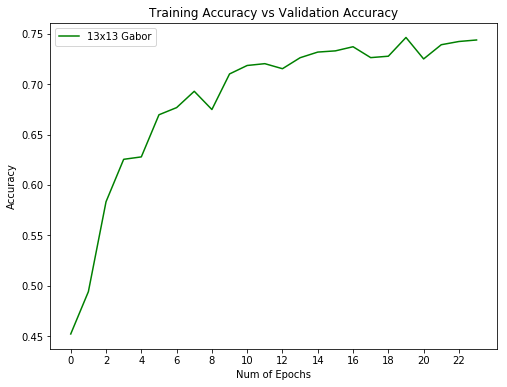

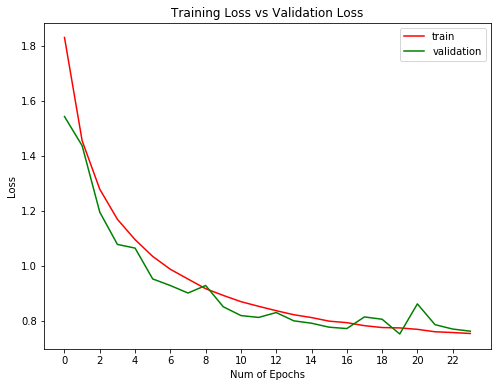

In [31]:
plt.figure(0)
# plt.plot(history_13x13['acc'],'r')
plt.plot(history_13x13['val_acc'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['13x13 Gabor'])


plt.figure(1)
# plt.plot(history_13x13['loss'],'r')
plt.plot(history_13x13['val_loss'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()